# Exploring the RNN architecture and implementing BPTT

In [5]:
import torch
from matplotlib import pyplot as plt
import random
from tqdm import tqdm

In [6]:
# Trying to create a simple 1 layer reccurance

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cpu')

In [9]:
# T controls depth in time of the computation graph you backprop through (how many unrolled steps).
# B controls width: how many independent sequences you process at the same time.
T = 64
B = 128
feature_dims = 1 # a singlur value or a 1D vec with 1 item is what we have as input data.

What is really important here is that RNNs work sequentially across a time-steps, i.e: `T` steps constitute one sequnce. So that axis cannot be parallelized, the only way we can parallelize/vectorize an RNN is by forming `batches` and computing each time-step `t_i` for all the sequences at once. It can be thought of as unpacking multiple sequences say seq_a ,seq_b, seq_c in the way of where step1 is where forward pass for `seq_a[0]`,`seq_b[0]` and `seq_c[0]` ( and their respective hidden state) computed in one shot.

In [10]:
class MyRNN(torch.nn.Module):
  def __init__(self, input_size, hidden_dims,output_size, batch_size = 1, hidden_state=None, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.hidden_dims = hidden_dims
    self.batch_size = batch_size

    self.W1 = torch.nn.Parameter(torch.rand((input_size,hidden_dims),device = device) * 0.01 )
    self.WH = torch.nn.Parameter(torch.rand((hidden_dims,hidden_dims),device = device)* 0.01)
    self.W2 = torch.nn.Parameter(torch.rand((hidden_dims,output_size),device = device)* 0.01)

    self.b1 = torch.nn.Parameter(torch.rand((hidden_dims,),device = device)* 0.01)
    self.b2 = torch.nn.Parameter(torch.rand((output_size,),device = device)* 0.01)

  def forward(self,x, hidden_state=None):
    T, B, _ = x.shape
    H = hidden_state if hidden_state is not None else torch.zeros((B,self.hidden_dims),device = x.device)

    for t in range(T):
      H = torch.tanh(x[t] @ self.W1 + H @ self.WH  + self.b1)

    y = torch.log_softmax(H @ self.W2 + self.b2, dim=1)

    return y, H

  def __str__(self) -> str:
      return f"RNN with {self.hidden_dims} hidden dims"

For understanding how even layers can be incorporated checkout the official docs example code [here](https://docs.pytorch.org/docs/stable/generated/torch.nn.RNN.html). But the basic idea is to have another inner loop inside `for t in range(T)` which loops over layers such that we walk the timestep through the full network for all items in the batch and each layer will contain its own hidden states.

Also another important caveat here is the above implementation of `MyRNN` includes a linear "projection" layer which transforms the hidden state in to a type of one-hot classification output. Depending on the learning task this can be altered to do other things using the `W_H` and hidden_state `H_prev_t` .


In [11]:
!pip install torchviz

In [12]:
from torchviz import make_dot

# 1. Instantiate your model
# hidden_dims=10, batch_size=5
model = MyRNN(input_size=1,hidden_dims=10, output_size=1, batch_size=5)

# 2. Create dummy input
# Sequence Length (T)=3, Batch Size (B)=5, Input Dim=1
x = torch.randn(3, 5, 1).to(device)

# 3. Forward pass
preds, _ = model(x)

# 4. Visualizing the graph
# We visualize 'preds' because it is the terminal node that connects back to everything
dot = make_dot(preds, params=dict(model.named_parameters()))

# 5. Render to file (requires Graphviz installed on your OS)
dot.format = 'png'
dot.render("rnn_computation_graph")

'rnn_computation_graph.png'

Since we have a sequence-length (T) as `3` , in the graph we should see ops on W_h happening 3 times along the chain ( look for sigmoid -> clone , should be seen x3 times)

## Dataset Prep


In [13]:
# delete any existing data
!rm -rf data

In [14]:
import requests
import zipfile
import os

# URL of the zip file
zip_url = "https://download.pytorch.org/tutorial/data.zip"
# Local path to save the zip file
zip_file_name = "data.zip"
# Directory to extract the contents into
extraction_path = "." # Changed to '.' to extract 'data' folder directly into current directory

print(f"Downloading {zip_url}...")
# Download the zip file
response = requests.get(zip_url, stream=True)
if response.status_code == 200:
    with open(zip_file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print(f"Downloaded {zip_file_name}")

    # Unzip the file
    if not os.path.exists(os.path.join(extraction_path, "data")):
        os.makedirs(os.path.join(extraction_path, "data")) # Ensure the target 'data' directory exists

    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)
    print(f"Extracted contents to {extraction_path}/data/") # Adjusted print statement

    # Optionally, remove the zip file after extraction
    os.remove(zip_file_name)
    print(f"Removed {zip_file_name}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

Downloaded data.zip
Extracted contents to ./data/
Removed data.zip


In [15]:
import string
import unicodedata

# We can use "_" to represent an out-of-vocabulary character, that is, any character we are not handling in our model
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [16]:
# Utils funcs

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    # return our out-of-vocabulary character if we encounter a letter unknown to our model
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [17]:
from io import open
import glob
import os
import time

from torch.utils.data import Dataset

class NamesDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir #for provenance of the dataset
        self.load_time = time.localtime #for provenance of the dataset
        labels_set = set() #set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        #read all the ``.txt`` files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        #Cache the tensor representation of the labels
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

In [18]:
alldata = NamesDataset("data/names")
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20074 items of data
example = (tensor([4]), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

## An RNN Classifier


In [19]:
rnn_clf_model = MyRNN(input_size = n_letters , hidden_dims= 128, output_size= len(alldata.labels_uniq) )
print(rnn_clf_model)
loss_fn = torch.nn.NLLLoss()
optm = torch.optim.Adam(rnn_clf_model.parameters(),lr = 0.001)

RNN with 128 hidden dims


In [20]:
def label_from_output(output, output_labels):
  top_n, top_i = output.topk(1)
  label_i = top_i[0].item()
  return output_labels[label_i], label_i

In [21]:
input = lineToTensor('Albert').to(device)
output,_ = rnn_clf_model(input) #this is equivalent to ``output = rnn.forward(input)``
print(label_from_output(output, alldata.labels_uniq))

('Dutch', 15)


In [22]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator().manual_seed(2024))
print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17063, validation examples = 3011


In [23]:
train_set.dataset[0][1].shape
# [ seq_len , batch , feature_dim ]

torch.Size([8, 1, 58])

In [24]:
train_set[0]

(tensor([2]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

To create batches we need to stack up these on dim 1

In [25]:
label_idx, oh_text_seq, label_txt, name_txt = train_set.dataset[0]
oh_text_seq.shape

torch.Size([8, 1, 58])

So we could try to do something like this but the sequence length is no uniform throughtout the dataset!


`torch.stack(train_set.dataset.data_tensors[:5],dim = 1).shape`

```
---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
/tmp/ipython-input-1277036370.py in <cell line: 0>()
----> 1 torch.stack(train_set.dataset.data_tensors[:5],dim = 1).shape

RuntimeError: stack expects each tensor to be equal size, but got [10, 1, 58] at entry 0 and [11, 1, 58] at entry 2

```

We will have to do this the old-school way with loops , meaning the batch dim vectorization is not possible for training in this case.


In [28]:
def train(
    model,
    train_set,
    optm,
    loss_fn,
    epoch = 5,
    clip_grads = False,
):
  loss_hist = []
  itr = tqdm(range(epoch))
  batch_size = 64
  batches = list(range(0,len(train_set),batch_size))

  for e in itr:
    random.shuffle(batches)
    model.zero_grad()
    for n,batch in enumerate(batches):
      batch_loss = 0
      for i in range(batch_size):
        if batch + i >= len(train_set):
          break

        (label_idx, oh_text_seq, label_txt, name_txt) = train_set[i+batch]
        # Move tensors to the correct device
        # oh_text_seq = oh_text_seq.to(device)
        # label_idx = label_idx.to(device)

        preds , h = model(oh_text_seq)
        # For sequence classification, use the prediction from the last time step.
        loss = loss_fn(preds,label_idx)
        batch_loss += loss

      # at the end of each batch, grad-update
      batch_loss /= batch_size
      batch_loss.backward()
      if clip_grads:
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
      optm.step()
      model.zero_grad()
      itr.set_description(f"Epoch {e+1}/{epoch} | Batch {n}/{len(batches)}")
    itr.set_postfix(loss=batch_loss.item())
    loss_hist.append(batch_loss.item())

  return loss_hist

In [33]:
model_with_grad_clipping = MyRNN(
    input_size = n_letters ,
    hidden_dims= 128,
    output_size= len(alldata.labels_uniq)
)
optm = torch.optim.Adam(model_with_grad_clipping.parameters(),lr = 0.001)
loss_fn = torch.nn.NLLLoss()

loss_h = train(
    model_with_grad_clipping,
    train_set,
    optm=optm,
    loss_fn=loss_fn,
    clip_grads=True,
    epoch=50
)

Epoch 27/27 | Batch 266/267: 100%|██████████| 27/27 [08:15<00:00, 18.37s/it, loss=0.441]


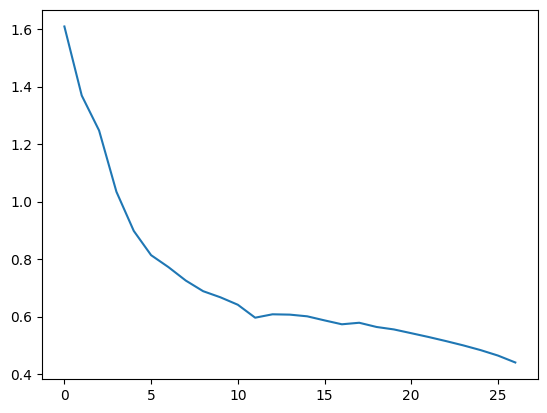

In [34]:
plt.plot(loss_h)

In [35]:
from matplotlib import ticker

# @title
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            text_tensor = text_tensor.to(device)
            output,_ = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

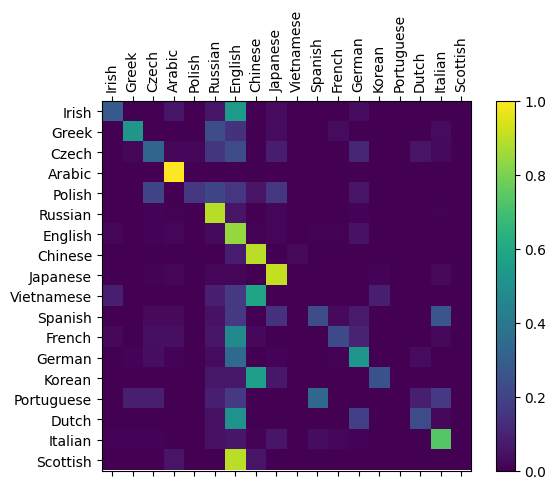

In [37]:
import numpy as np
evaluate(model_with_grad_clipping, test_set, classes=alldata.labels_uniq)

## Too Slow this takes way too long , but why ?

Out implementation has a bunch of inefficients,
- Massive kernel-launch overhead , because we are doing one forward() call per sequence.
  
  GPU sees: `(sequence_len) × 64 tiny matmuls + activations + softmaxes + clones… ` per update.
  
  It is true that we are doing so because we have sequences of variable length,
  but it can still be improved by :
  - batch/bucketing inputs based on sequence len and then generating a batch
  - Using padding from torch util specifically designed for this [see this](https://docs.pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html)

- We are also storing gradient history and stacking them in the forward pass but only using the output of the last item of sequence, this can also be avoided for the particular usecase.

- We are also doing sync ops during trainign loop like sending the OH_vec `.to(device)` and `.clone()` (which we never use later) which slows things down.


If you look at the torch source you will find that they do both these things out of the box: support for packed sequences and also a kernal optimized unrolling of timesteps. [Github](https://github.com/pytorch/pytorch/blob/v2.9.1/torch/nn/modules/rnn.py#L654) , you can see these `_VF` functions (from torch._VF) are highly optimized C++/CUDA implementations that process somewhere [here](https://github.com/pytorch/pytorch/blob/888a4a03/aten/src/ATen/native/RNN.cpp#L722-L733). The forward method doesn't contain time step loops and is done at the CPP level.



## Using PyTorch Anyway
Ventured deep enough into torch for now trying to implement RNN with just autograd, the goal of understand the internals conceptually is complete , the engineering done for the optimizations requires its own re-visit which i'll skip for now and start using torch directly with the goal to experiment with the archirtecture vs experiments on implementation itself.

In [38]:
class tRNN(torch.nn.Module):
  def __init__(self, input_size, hidden_dims,output_size, batch_size = 1, hidden_state=None, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.hidden_dims = hidden_dims
    self.batch_size = batch_size
    self.rnn = torch.nn.RNN(
        input_size=input_size,
        hidden_size=hidden_dims,
        num_layers=1,
        device=device
    )
    self.linear = torch.nn.Linear(hidden_dims, output_size,device=device)
    self.softmax = torch.nn.LogSoftmax(dim=1)

  def forward(self,x, hidden_state=None):
    if x.device != device:
      x = x.to(device)

    H, hidden_state = self.rnn(x)
    out = self.softmax(self.linear(hidden_state[-1]))

    return out



In [39]:
model = tRNN(
    input_size = n_letters ,
    hidden_dims= 128,
    output_size= len(alldata.labels_uniq)
)

In [40]:
loss_fn = torch.nn.NLLLoss()
optm = torch.optim.SGD(model.parameters(),lr = 0.001)

In [41]:

def new_train(
    model,
    train_set,
    optm,
    loss_fn,
    epoch = 5,
    clip_grads = False,
):
  loss_hist = []
  itr = tqdm(range(epoch))
  batch_size = 64
  batches = list(range(0,len(train_set),batch_size))
  random.shuffle(batches)

  for e in itr:
    model.zero_grad()
    for n,batch in enumerate(batches):
      batch_loss = 0
      for i in range(batch_size):
        if batch + i >= len(train_set):
          break

        (label_idx, oh_text_seq, label_txt, name_txt) = train_set[i+batch]
        # Move tensors to the correct device
        oh_text_seq = oh_text_seq.to(device)
        label_idx = label_idx.to(device)

        preds = model.forward(oh_text_seq)
        # For sequence classification, use the prediction from the last time step.
        loss = loss_fn(preds,label_idx)
        batch_loss += loss

      # at the end of each batch, grad-update
      batch_loss /= batch_size
      batch_loss.backward()
      if clip_grads:
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
      optm.step()
      loss_hist.append(batch_loss.item())
      model.zero_grad()

      itr.set_description(f"Epoch {e+1}/{epoch} | Batch {n}/{len(batches)}")
      itr.set_postfix(loss=batch_loss.item()/batch_size)
  return loss_hist

In [42]:
loss_hist = new_train(
    model= model,
    train_set=train_set,
    optm=optm,
    loss_fn=loss_fn,
    clip_grads=True,
    epoch=27
)

Epoch 27/27 | Batch 266/267: 100%|██████████| 27/27 [08:11<00:00, 18.21s/it, loss=0.0238]


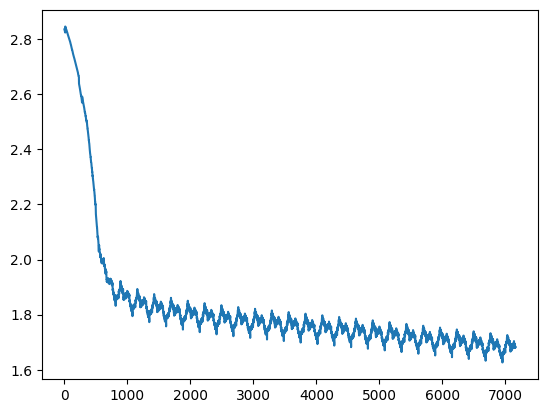

In [43]:
# @title
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.plot(moving_average(loss_hist, window_size=50))

In [44]:
from matplotlib import ticker

# @title
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            text_tensor = text_tensor.to(device)
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

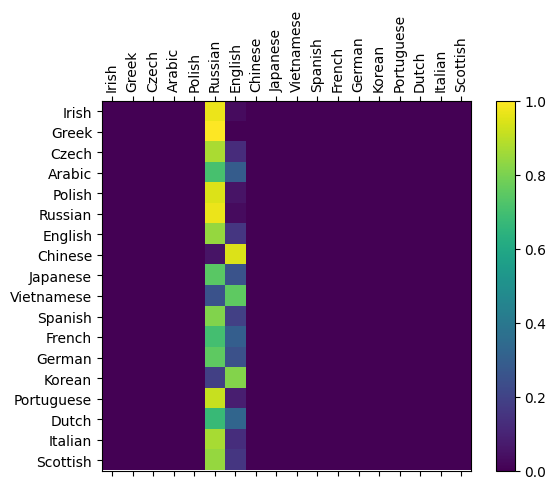

In [45]:
evaluate(model, test_set, classes=alldata.labels_uniq)